In [23]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from scipy import stats
from scipy.special import expit as logistic
from math import exp
from scipy.special import softmax
d = pd.read_csv("Data/chimpanzees.csv", sep=";")

RANDOM_SEED = 4597

In [24]:
d.head()


,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [25]:
with pm.Model() as chimp_model_fixed:
    a = pm.Normal("a", 0, 1.5, shape=d.actor.nunique())
    b = pm.Normal("b",0,0.5, shape=2)
    
    p = pm.Deterministic("p", pm.math.invlogit(a[d.actor-1] + b[d.prosoc_left]*d.condition))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_fix = pm.sample_prior_predictive(random_seed=RANDOM_SEED,samples=10_000)
    prior_fix_dat = az.from_pymc3(prior=prior_fix)
    
    post_fix = pm.sample(random_seed=RANDOM_SEED,draws=10_000,return_inferencedata=True)
    post_fix_dat = az.InferenceData.to_dataframe(post_fix)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 141 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

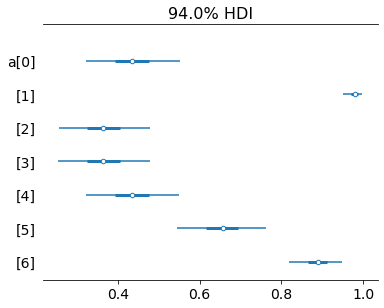

In [26]:
az.plot_forest(post_fix, var_names=["a"], transform=logistic, combined=True)

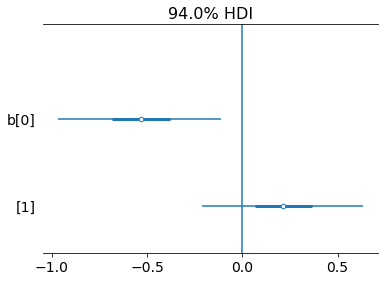

In [27]:
az.plot_forest(post_fix, var_names=["b"], combined=True)
plt.axvline(0)

In [28]:
with pm.Model() as chimp_model_random:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    a_sigma = pm.Exponential("a_sigma", 1.0)
    a = pm.Normal("a", a_bar, a_sigma, shape=d.actor.nunique())
    b = pm.Normal("b",0,1, shape=2)
    
    p = pm.Deterministic("p", pm.math.invlogit(a[d.actor-1] + b[d.prosoc_left]*d.condition))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_rand = pm.sample_prior_predictive(random_seed=RANDOM_SEED,samples=10_000)
    prior_rand_dat = az.from_pymc3(prior=prior_fix)
    
    post_rand = pm.sample(random_seed=RANDOM_SEED,draws=10_000,return_inferencedata=True, target_accept=0.99)
    post_rand_dat = az.InferenceData.to_dataframe(post_fix)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, a_sigma, a_bar]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 346 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

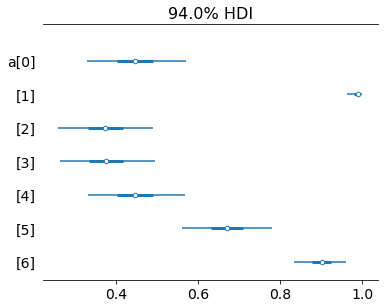

In [31]:
az.plot_forest(post_rand, var_names=["a"], transform=logistic, combined=True)

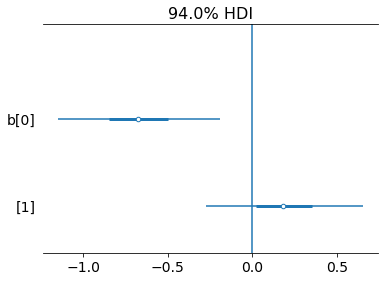

In [32]:
az.plot_forest(post_rand, var_names=["b"], combined=True)
plt.axvline(0)

In [33]:
az.compare(post_fix,post_rand)

AttributeError: 'InferenceData' object has no attribute 'lower'